Name: Saifuddin Telia
G#: G01229939
Miner name: stelia
Masonid: stelia
Last viewed Rank: 52 
Accuracy acheived: 0.83

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from scipy import spatial

import sklearn

import statistics

import gc

import matplotlib.pyplot as plt

In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

First I made a cleaning function to clean my train data so that I can use it to build my knn algorithm.
I did the basic cleaning stuff like converting my text to lowercase, removing punctuation and removing stopwords. I read online then that removing stopwords is a good practice and I removed those as well. But then I thought since we had to do sentiment analysis and words such as not nor don't are necessary, I removed them from the stopwords list and used my own custom stopwords list. I also lemmatized my words to their roots which helped in improving my accuracy by 2%.

In [3]:
# function for cleaning

def knnClean(filename):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"] # storing all stopwords in a variable to reduce time
  lemmatizer = WordNetLemmatizer()

  train = pd.read_csv(filename, sep="\t")

  for i in range(len(train)):
      senToken = tokenizer.tokenize((train["review"][i]).lower()) # convert to lowercase, remove punctuation and tokenize in the senToken List
      senToken = [s for s in senToken if s not in stop_words] # removing stopwords
      senToken = [s for s in senToken if len(s) > 2] # remove words less than legnth 2
      senToken = [lemmatizer.lemmatize(s) for s in senToken] # lemmatize data
      train["review"][i] = " ".join(senToken) # convert list to sentence and replace original sentance
  
  return train

cleanDF = knnClean("./train_file.txt")

<ipython-input-3-aa5d3428dd59>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["review"][i] = " ".join(senToken) # convert list to sentence and replace original sentance


For my training phase, I used holdout method to split my train data into 8:2 parts for training and testing. I went with TF-IDF vectorization from the begining itself since it gives importance to the rarity of a word to reflect how important that word is to the document in our corpus. At first, I experimented majorly while vectorizing my data. I vectorized my x-axis normally, then with an ngram range of [1,2], then with min_df and max_features = 50,000 once and 75,000 next. Trying and testing these different vectorizations gave me different accuracies and the highest one I got was with ngram_range = (1,2), max_features=75000, min_df = 2 and I decided to use it. I got an accuracy of 0.83 in the end on miner. For calculating the distance I used cosine similarity from the start because the magnitude of the vectors do not matter when working with text data and using euclidean distance didn't make sense

In [4]:
# hold-out method

x_axis = cleanDF["review"]
y_axis = cleanDF["sentiment"]

tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), max_features=75000, min_df = 2)
# tf_idf_vect = TfidfVectorizer(min_df = 2)
final_tf_idf = tf_idf_vect.fit_transform(x_axis)

review_array = np.asarray(final_tf_idf.toarray()) # array for iterating

# create training and testing vars
x_train, x_test, y_train, y_test = train_test_split(review_array, y_axis, test_size=0.2, random_state=42, shuffle=True)

# convert pandas y_train and y_test to numpy
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

# calculate cosine distance
x_dist = 1 - sklearn.metrics.pairwise.cosine_similarity(x_test, x_train, dense_output=True)

What I implemented below is a normal knn algorithm without weighted majority voting first just to check. I plotted the graph of accuracy vs k and even printed all individual k and accuracies accordingly to get the best possible k from the local maxima. Got k = 181 and accuracy = 0.8403333333333334.

3 :  0.729
5 :  0.747
7 :  0.755
9 :  0.7636666666666667
11 :  0.7713333333333333
13 :  0.7776666666666666
15 :  0.7873333333333333
17 :  0.788
19 :  0.7903333333333333
21 :  0.7906666666666666
23 :  0.7933333333333333
25 :  0.7983333333333333
27 :  0.7986666666666666
29 :  0.8043333333333333
31 :  0.8033333333333333
33 :  0.801
35 :  0.805
37 :  0.8076666666666666
39 :  0.8096666666666666
41 :  0.805
43 :  0.8096666666666666
45 :  0.8093333333333333
47 :  0.8103333333333333
49 :  0.8123333333333334
51 :  0.8123333333333334
53 :  0.816
55 :  0.8163333333333334
57 :  0.8186666666666667
59 :  0.8153333333333334
61 :  0.8183333333333334
63 :  0.8173333333333334
65 :  0.818
67 :  0.8176666666666667
69 :  0.8183333333333334
71 :  0.8203333333333334
73 :  0.8223333333333334
75 :  0.822
77 :  0.8223333333333334
79 :  0.8223333333333334
81 :  0.8226666666666667
83 :  0.8256666666666667
85 :  0.823
87 :  0.8233333333333334
89 :  0.8236666666666667
91 :  0.827
93 :  0.826
95 :  0.825
97 :  0.826

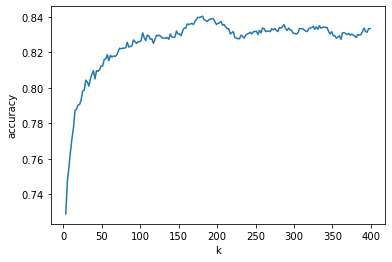

In [9]:
# function for training without weighted majority voting

def knnCheck(k, x_dist):
    y_check = [] # the final predictions will be stored here

    for vector in x_dist:
      k_neighbours = np.argsort(vector)[:k] # get the index of the closest k neighbors

      k_sentiments = [] # the sentiments of the closest k neighbours are stored in here
      for i in k_neighbours:
        k_sentiments.append(y_train_np[i]) # get the sentiments of the closest k neighbours

      y_check.append(statistics.mode(k_sentiments)) # append the sentiment which wins majority voting

    #calculate accuracy of the final predictions
    accuracy = sum(1 for x, y in zip(y_check, y_test_np) if x == y) / len(y_check)

    return accuracy

#lists for plotting
plot_k, plot_acc = [], []

for k in range(3,400,2):
    accuracy = knnCheck(k, x_dist)
    print(k, ": ", accuracy) # checking all k and accuracy values for debugging purposes
    plot_k.append(k)
    plot_acc.append(accuracy)

#plotting the graph
plt.plot(plot_k, plot_acc)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

The below code is my weighted majority voting implementation. I got k = 179 and accuracy = 0.8423333333333334

3 :  0.7303333333333333
5 :  0.7496666666666667
7 :  0.758
9 :  0.7663333333333333
11 :  0.7756666666666666
13 :  0.7806666666666666
15 :  0.791
17 :  0.7906666666666666
19 :  0.792
21 :  0.7916666666666666
23 :  0.7956666666666666
25 :  0.7996666666666666
27 :  0.8013333333333333
29 :  0.8063333333333333
31 :  0.806
33 :  0.8033333333333333
35 :  0.806
37 :  0.811
39 :  0.811
41 :  0.8096666666666666
43 :  0.813
45 :  0.8123333333333334
47 :  0.8116666666666666
49 :  0.815
51 :  0.8153333333333334
53 :  0.8176666666666667
55 :  0.82
57 :  0.822
59 :  0.8183333333333334
61 :  0.8226666666666667
63 :  0.8203333333333334
65 :  0.8193333333333334
67 :  0.8193333333333334
69 :  0.8226666666666667
71 :  0.8226666666666667
73 :  0.825
75 :  0.8266666666666667
77 :  0.8256666666666667
79 :  0.8246666666666667
81 :  0.8233333333333334
83 :  0.826
85 :  0.8263333333333334
87 :  0.8273333333333334
89 :  0.8256666666666667
91 :  0.83
93 :  0.829
95 :  0.8286666666666667
97 :  0.8276666666666667
9

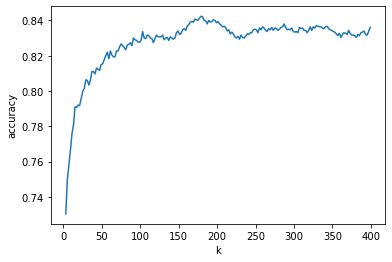

In [11]:
# function for training with weighted majority voting

def knnCheck(k, x_dist):
    y_check = [] # the final predictions will be stored here

    for vector in x_dist:
      k_neighbours = np.argsort(vector)[:k] # get the index of the first closest k neighbors

      # variables to store the weights of the 1s and -1s in each k_neighbours
      weighted_1, weighted_min1 = 0, 0
      
      for i in k_neighbours:
        if y_train_np[i] == 1: # if prediction is 1 then calculated it's weight
            if vector[i] == float(0): # To handle a case if my denominator is zero
                weighted_1 += (100000000 ** 2)
            else:
                weighted_1 += ((1/vector[i]) ** 2)
        if y_train_np[i] == -1: # if prediction is -1 then calculated it's weight
            if vector[i] == float(0): # To handle a case if my denominator is zero
                weighted_min1 += (100000000 ** 2)
            else:
                weighted_min1 += ((1/vector[i]) ** 2)

      # append 1 or -1 depending on which one weighs more
      y_check.append(1 if (weighted_1 > weighted_min1) else -1)
    
    # calculate accuracy
    accuracy = sum(1 for x, y in zip(y_check, y_test_np) if x == y) / len(y_check)

    return accuracy

#lists for plotting
plot_k, plot_acc = [], []

for k in range(3,400,2):
    accuracy = knnCheck(k, x_dist)
#     print(k, ": ", accuracy) # checking all k and accuracy values for debugging purposes
    plot_k.append(k)
    plot_acc.append(accuracy)

#plotting the graph
plt.plot(plot_k, plot_acc)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

The below code is almost exactly the same but this time it uses the train file to generate a prediction output on the test file. I used the best k I got from the above training phase to submit the final file on miner.

In [12]:
# final cleaning

def knnClean(train):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"] # storing all stopwords in a variable to reduce time
  lemmatizer = WordNetLemmatizer()

  for i in range(len(train)):
      senToken = tokenizer.tokenize((train["review"][i]).lower()) # convert to lowercase, remove punctuation and tokenize in the senToken List
      senToken = [s for s in senToken if s not in stop_words] # removing stopwords
      senToken = [s for s in senToken if len(s) > 2] # remove words less than legnth 2
      senToken = [lemmatizer.lemmatize(s) for s in senToken] # lemmatize data
      train["review"][i] = " ".join(senToken) # convert list to sentence and replace original sentance

train = pd.read_csv("./train_file.txt", sep="\t")
# test = pd.read_csv("test_file.txt", sep="\t", header=None, names=['review'])
my_file = open("./test_file.txt", "r", encoding="utf8")
content_list = my_file.read().split("\n")
my_file.close()
test = pd.DataFrame(content_list, columns =['review'])
test = test[:-1]

knnClean(train)
knnClean(test)

<ipython-input-12-3de3121d4c3d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["review"][i] = " ".join(senToken) # convert list to sentence and replace original sentance


In [13]:
x_axis_train = train["review"]
y_axis_train = train["sentiment"]
x_axis_test = test["review"]

tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), max_features=75000, min_df = 2)
# tf_idf_vect = TfidfVectorizer(min_df = 2)
final_tf_idf_train = tf_idf_vect.fit_transform(x_axis_train)
final_tf_idf_test = tf_idf_vect.transform(x_axis_test)
# final_tf_idf_train.shape, type(final_tf_idf_train), final_tf_idf_test.shape, type(final_tf_idf_test)

x_train, x_test, y_train = np.asarray(final_tf_idf_train.toarray()), np.asarray(final_tf_idf_test.toarray()), np.asarray(y_axis_train)
# x_train.shape, x_test.shape, y_train.shape, type(x_train), type(x_test), type(y_train)

# calculate cosine distance
x_dist = 1 - sklearn.metrics.pairwise.cosine_similarity(x_test, x_train, dense_output=True)
# x_dist.shape, type(x_dist), x_dist

In [14]:
# final classifier

def knnClassify(k, x_dist):
    y_check = [] # the final predictions will be stored here

    for vector in x_dist:
        k_neighbours = np.argsort(vector)[:k] # get the index of the first closest k neighbors
        
        # variables to store the weights of the 1s and -1s in each k_neighbours
        weighted_1, weighted_min1 = 0, 0
        
        for i in k_neighbours:
            if y_train[i] == 1: # if prediction is 1 then calculated it's weight
                if vector[i] == float(0): # To handle a case if my denominator is zero
                    weighted_1 += (10000000000000000)
                else:
                    weighted_1 += ((1/vector[i]) ** 2)
            if y_train[i] == -1: # if prediction is -1 then calculated it's weight
                if vector[i] == float(0): # To handle a case if my denominator is zero
                    weighted_min1 += (10000000000000000)
                else:
                    weighted_min1 += ((1/vector[i]) ** 2)
        
        # append 1 or -1 depending on which one weighs more
        y_check.append(1 if (weighted_1 > weighted_min1) else -1)
    
    # save the final predictions in a test file for submitting on miner
    MyFile = open('./formatfiles/format_file_k_'+str(k)+'.txt','w')
    for element in y_check:
        MyFile.write(str(element)+"\n")
    MyFile.close()

knnClassify(179, x_dist)
